# Introduction

We will be training a variational autoencoder as part of training a generative model to generate digits based on MNIST data. The variational autoencoder is an unsupervised method to find embeddings in a lower dimensional space, using an Encoder and a Decoder. The Encoder maps input data in some space $X$ into an embedding space $Z$, typically of lower dimension than $X$, and the Decoder maps encoded (embedded) data from $Z$ back into $X$ space, also denoted $O$ for output space.

Let $\phi$ represent the parameters of the Encoder and $\theta$ the parameters of the Decoder. Then we want to train our autoencoder by minimizing the distance between our input data $X$ and the output data produced by encoding then decoding the input data:
$$min_{\theta, \phi}\sum_{i=1}^N d(X_i, Dec(En(X,\phi),\theta))$$

We'll use logistic loss, so our distance metric becomes the "binary cross-entropy" loss:
$$d(x, Dec(En(X,\phi), \theta))=-\sum_{s}x_s\textrm{ log }Dec(En(x,\phi), \theta)_s-(1-x_s)\textrm{ log }[1-Dec(En(x,\phi), \theta)_s]$$

For the variational autoencoder, our embedding space isn't an explicit "encoding" of the input data $X$, but rather an embedding of the mean and variance of the input. When we decode this embedding, we take the mean $\mu(X)$ and variance $\sigma(X)$ and sample some $Z=\mu(X)+\epsilon\cdot\sigma(X)$ where $\epsilon\sim N(0,I)$ is some noise.

Our loss therefore has a second component based on this "embedding" distribution, which is:
$$-\frac{1}{2}\sum_{j=1}^d 1+\textrm{log }\sigma_j^2(X_i)-\mu_j(X_i)^2-\sigma_j^2(X_i)$$

Once we have an Encoder and a Decoder trained, we can use the Decoder as a generative model. We simply sample from a standard normal and attempt to "decode" this distribution. This has some minor issues, as we'll see once we train the model.

# Fréchet inception distance

The Fréchet inception distance measures the quality of images generated by a generative model by comparing its distribution to the distribution of the original data. To measure how successful our generative model is, we'll calculate the FID between the generated data and the initial data.

Let $\mu_G,\Sigma_G$ be the mean and covariances of the generated distribution $P_G$, and let $\mu_D,\Sigma_D$ be the mean and covariances of the data distribution $P_D$. Then define the FID as
$$|\mu_G-\mu_D|^2+tr\left[ \Sigma_G + \Sigma_D - 2(\Sigma_G^{1/2}\Sigma_D\Sigma_G^{1/2})^{1/2} \right]$$

where for a symmetric matrix $M$ with spectral decomposition $U\Lambda U^\top$ we write $M^{1/2}=U\sqrt{\Lambda}U^\top$

In [20]:
import numpy as np
import numpy.linalg as la

def sqrt_mat(A):
  # For a symmetric matrix A w/ spectral decomposition A=ULU.T, define
  # A^{1/2} as U*sqrt(L)*U.T
  eigvals, eigenvecs = la.eig(A)
  return np.dot(np.dot(eigenvecs, np.diag(np.sqrt(eigvals))), eigenvecs.T)

def fid_dist(G, D):
  # Frechet inception distance:
  # |mu_G - mu_D|^2 + tr[Sigma_G + Sigma_D - 2(Sigma_G^{1/2}*Sigma_D*Sigma_G^{1/2})^{1/2}]
  mu_g = np.mean(G)
  mu_d = np.mean(D)
  s_g = np.cov(G)
  s_d = np.cov(D)
  # first term, the distance between means
  dist = mu_g - mu_d
  term1 = dist**2
  # second term, the trace of covariances
  # second term, the trace of covariances
  sqrt_s_g = sqrt_mat(s_g)
  term2 = np.trace(s_g + s_d - 2*sqrt_mat(sqrt_s_g @ s_d @ sqrt_s_g))

  return (term1 + term2)

Next, we quickly test the sqrt function:

In [2]:
# Expect to square the square roots and get back same matrix
def test_sqrt(A):
  # generate PSD/symm matrix
  A_symm = (A @ A.T)/2
  A_sqrt = sqrt_mat(A_symm)
  A_prod = A_sqrt @ A_sqrt
  # find distance between square of sqrt and symm matrix
  dist = la.norm(A_prod - A_symm)**2
  assert(dist < 1e-6)

test1 = np.random.randint(-2000,2000,size=(10,10))
test2 = np.random.randint(-2000,2000,size=(10,10))
test3 = np.diag(np.ones(100))
test_sqrt(test1)
test_sqrt(test2)
test_sqrt(test3)

# Preparing data

First, we import the data and create training, validation, and test sets.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'
else:
    predir = os.path.join('Users','pagli','Google Drive')
    if os.path.isdir(os.path.join(predir,'My Drive')):
            predir=os.path.join(predir,'My Drive')

import torch
import numpy as np

# Torch functions, used later
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
from tqdm.notebook import trange, tqdm

# Folder holding the data
datadir=predir+'LSDA_data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
Mounted at ME


In [4]:
def get_mnist():
    data=np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print('data shape:', data.shape)
    data=np.float32(data)/255.
    # 50,000 training samples, 10,000 validation and test samples
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [5]:
# If we want, we should be able to use any dataset, but the code
# currently only supports 28x28 images. To add more options, we would
# need to add the name of the option here and create a new function
# modelled after "get_mnist" above.
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    else:
      return None

# VAE Architecture
We write the VAE architecture using pytorch. We need three classes: an encoder, a decoder, and a (variational) auto-encoder which contains both the encoder and the decoder.

First, the encoder: we want an input layer of dimension $28\cdot28=784$, a hidden linear layer of some dimension $h$ with ReLU non-linearity, and a linear embedding layer of some dimension $2d$ (for means and log variances's).

In [6]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self,pars):
        super(Encoder, self).__init__()

        inp_dim = pars.s
        h_dim = pars.h
        emb_dim = pars.d

        self.input_layer = nn.Linear(inp_dim, h_dim)
        self.hidden_layer = nn.Linear(h_dim, h_dim)
        # we could alternatively define the means and variances together as one
        # layer of output size (2 * emb_dim)
        self.means = nn.Linear(h_dim, emb_dim)
        self.variances = nn.Linear(h_dim, emb_dim)

    def forward(self, x):
        # input data -> input layer -> hidden layer -> means and variances layers
        o = F.relu(self.hidden_layer(F.relu(self.input_layer(x))))
        mean = self.means(o)
        # recall that these are log variances
        variances = self.variances(o)
        return mean, variances

Next, the decoder: we want an embedding (input to decoder) layer of dimension $d$, a linear layer of dimension $h$ with ReLU non-linearity, and an output layer of dimension $s$ with sigmoid non-linearity. Note that our input here is of dimension $d$, meaning we need to sample the encoded distribution before plugging our encoding into the decoder.

In [7]:
class Decoder(nn.Module):
    def __init__(self,pars):
        super(Decoder, self).__init__()

        emb_dim = pars.d
        h_dim = pars.h
        s_dim = pars.s
        self.emb_layer = nn.Linear(emb_dim, h_dim)
        self.hidden_layer = nn.Linear(h_dim, h_dim)
        self.output_layer = nn.Linear(h_dim, s_dim)

    def forward(self, x):
        # sample from encoded distribution -> embedding (input) layer ->
        #   hidden layer -> output layer
        o = F.relu(self.hidden_layer(F.relu(self.emb_layer(x))))
        preds = torch.sigmoid(self.output_layer(o))
        return preds

Finally, the autoencoder: we take an encoder and a decoder, and implement methods to sample the encoded distribution as well as run gradient descent using the loss described in the introduction.

In [8]:
class AE(nn.Module):
    def __init__(self, pars, enc, dec, doVariational=True):
        super(AE, self).__init__()

        self.Encoder = enc
        self.Decoder = dec
        # if doVariational = False, we don't use noise, which is equivalent to
        # just a regular Autoencoder: we treat the mean/variances as summand
        # layers which produce an explicit encoding. No real "sampling" is done
        # to get the actual embedding Z
        self.doNoise = doVariational
        self.pars = pars
        self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        self.first = True

    def calculate_Z(self, mean, var):
        noise = torch.randn_like(var).to(self.pars.device)
        if self.doNoise:
          # We assume that the variances are LOG variances, so take the exponential
          z = mean + (torch.exp(var) * noise)
        else:
          # No noise, so simply sum the layers (equivalent to a single
          # non-stochastic layer)
          z = mean + torch.exp(var)
        return z

    def forward(self, x):
        # input data -> encode -> sample encoding -> decode
        mean, variances = self.Encoder(x)
        if self.first:
            print('means', mean.shape)
            print('variances', variances.shape)
        z = self.calculate_Z(mean, variances)
        pred = self.Decoder(z)
        if self.first:
            print('z', z.shape)
            print('pred', pred.shape)
            self.first = False
        return pred, mean, variances

    def get_loss(self, data, targ):
        # embed data to get output (decoded embedding)
        output, mean, variances = self.forward(data)
        # From the introduction:
        # Loss is sum of -log(p(X|r(O), theta)) ...
        loss = F.binary_cross_entropy(output, targ, reduction='sum')
        # ... and 1/2 sum (1 + log(variances) - means^2 - variances)
        loss += (-0.5 * torch.sum(1+variances-torch.pow(mean, 2)-torch.exp(variances)))

        return loss

    def run_grad(self, data, targ):
        loss = self.get_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

# Training the model

We train the model using stochastic gradient descent with a given batch size (chosen here to be 1,000 samples)

In [9]:
def run_epoch(net,epoch,train,pars,num=None):
    n=train[0].shape[0]
    if (num is not None):
        # optionally run less training data
        n=np.minimum(n,num)
    ii=np.array(np.arange(0,n,1))
    np.random.shuffle(ii)
    # reshape to get shape (..., 784) from (..., 1, 28, 28)
    tr=train[0][ii].reshape((ii.size, 784))
    train_loss=0

    # train in random batches of given size
    for j in trange(0,n,pars.batch_size):

        # Transfer the batch from cpu to gpu (or do nothing if on a cpu)
        data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)

        # Implement SGD step on batch
        # (Target is the same as the original data)
        loss = net.run_grad(data,data)

        train_loss += loss.item()

    train_loss /= (len(ii))
    print(f'\nTraining set epoch {epoch}: Average loss: {train_loss:.4f}\n')
    return train_loss

In [10]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
        test_loss = 0
        # reshape to get shape (..., 784) from (..., 1, 28, 28)
        vald = val[0].reshape(val[1].size, 784)
        # For every validation (or test) sample, calculate distance of decoded
        # embedding to original data
        for j in np.arange(0,len(vald),pars.batch_size):
            data = torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
            loss = net.get_loss(data,data)
            test_loss += loss.item()

        test_loss /= len(vald)
        test_type = 'Validation'
        if (ttype =='test'):
            test_type = 'Test'
        print(f'\n{test_type} set: Avg. loss: {test_loss:.4f}\n')
        return test_loss

In [11]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=30
        self.numtrain=50000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.d = 10
        self.h = 256
        self.s = 784
        self.use_gpu=True

pars=par()

Running the epochs:

In [12]:
# use GPU when possible
pars.device = device
train,val,test=get_data(data_set=pars.data_set)
# Initialize the network
enc = Encoder(pars)
dec = Decoder(pars)
net = AE(pars, enc, dec).to(pars.device)
# Post it to the gpu if it's there.
net.to(pars.device)

train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain)
    # Test on validation set.
    net_test(net,val,pars)

net_test(net,test,pars,ttype="test")

# Optional: save the model to a file

# if not os.path.isdir(os.path.join(datadir,'tmp')):
#     os.mkdir(os.path.join(datadir,'tmp'))
# torch.save(net.state_dict(), os.path.join(datadir,'tmp',pars.model_name))

data shape: (70000, 784)


  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 10])
variances torch.Size([1000, 10])
z torch.Size([1000, 10])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 265.1649


Validation set: Avg. loss: 203.6113



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 200.6200


Validation set: Avg. loss: 197.0163



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 193.3629


Validation set: Avg. loss: 188.1010



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 183.6999


Validation set: Avg. loss: 177.3816



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 173.7562


Validation set: Avg. loss: 166.2530



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 159.6021


Validation set: Avg. loss: 150.6673



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 145.3162


Validation set: Avg. loss: 139.4559



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 137.6453


Validation set: Avg. loss: 133.4428



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 132.3042


Validation set: Avg. loss: 128.9675



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 128.7091


Validation set: Avg. loss: 126.1780



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 125.6366


Validation set: Avg. loss: 122.7571



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 122.4967


Validation set: Avg. loss: 119.9023



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 119.5897


Validation set: Avg. loss: 116.9005



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 116.4039


Validation set: Avg. loss: 113.7957



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 113.7172


Validation set: Avg. loss: 111.4685



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 111.8541


Validation set: Avg. loss: 110.0105



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 110.4050


Validation set: Avg. loss: 108.7417



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 109.2268


Validation set: Avg. loss: 107.5979



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 108.2458


Validation set: Avg. loss: 106.7407



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 107.2579


Validation set: Avg. loss: 105.9976



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 106.3962


Validation set: Avg. loss: 105.1812



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 105.7164


Validation set: Avg. loss: 104.4639



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 105.0002


Validation set: Avg. loss: 104.0102



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 104.4491


Validation set: Avg. loss: 103.3170



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 103.8091


Validation set: Avg. loss: 102.9134



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 103.3790


Validation set: Avg. loss: 102.4379



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 102.8339


Validation set: Avg. loss: 101.9507



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 102.4935


Validation set: Avg. loss: 101.5652



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 102.0178


Validation set: Avg. loss: 101.3181



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 101.6409


Validation set: Avg. loss: 100.9383


Test set: Avg. loss: 101.9809



# Viewing reconstructed images

Here we provide examples of reconstructed images. We simply run the chosen example digits through the variational autoencoder, which encodes then decodes the digits, reconstructing the digits from the encoded distribution.

In [13]:
import matplotlib.pyplot as plt
import pylab as py

# Helper to display some chosen number of digits
def show_digits(examples, nrows, ncols, title):
  plt.figure(figsize=(ncols*2, nrows*2))
  plt.suptitle(title, size='xx-large')
  for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(examples[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
  plt.show()

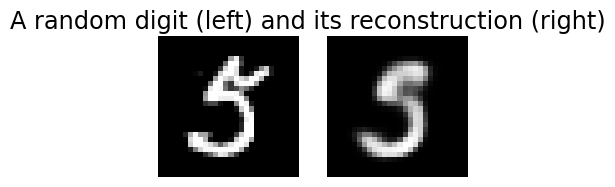

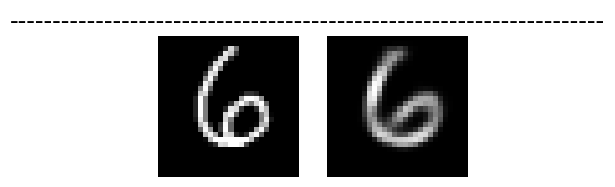

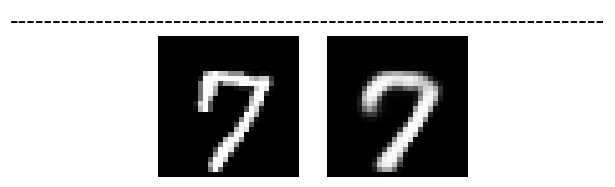

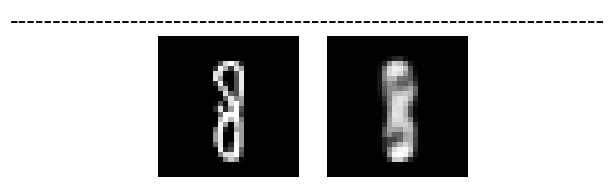

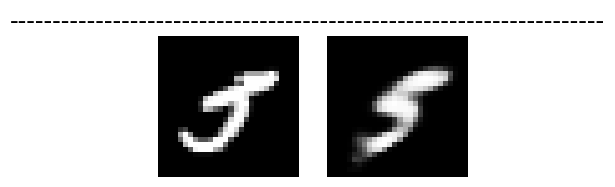

In [14]:
# Choose random digits
idxs = np.random.randint(test[1].size, size=5)
# Show reconstructions
first = True
for idx in idxs:
  rand_img = test[0][idx].reshape((1, 784))
  rec_img, _, _ = net(torch.from_numpy(rand_img).to(pars.device))
  if first:
    title = "A random digit (left) and its reconstruction (right)\n"
    first = False
  else:
    title = "---------------------------------------------------------------------"
  # need to make tensor into nparray to display
  show_digits([rand_img, rec_img.cpu().detach().numpy()], 1, 2, title)

# Generative noise

Here we sample a standard normal about 100 times, displaying the "decoded" (generated) digits using the decoder on the samples. You can see below that this works somewhat well, but we're limited by a few things. First of all, the model has not been tuned; I simply chose a few hyperparameters which seemed fine, and this is the result. Furthermore, the embedding space is extremely small. I chose to use a dimension of 10 to match there being 10 digits, but this doesn't capture all of the variation of digits; for example, 4 can be written with either a triangular or box-shaped top. An embedding dimension of 20 or even 40 might work better.

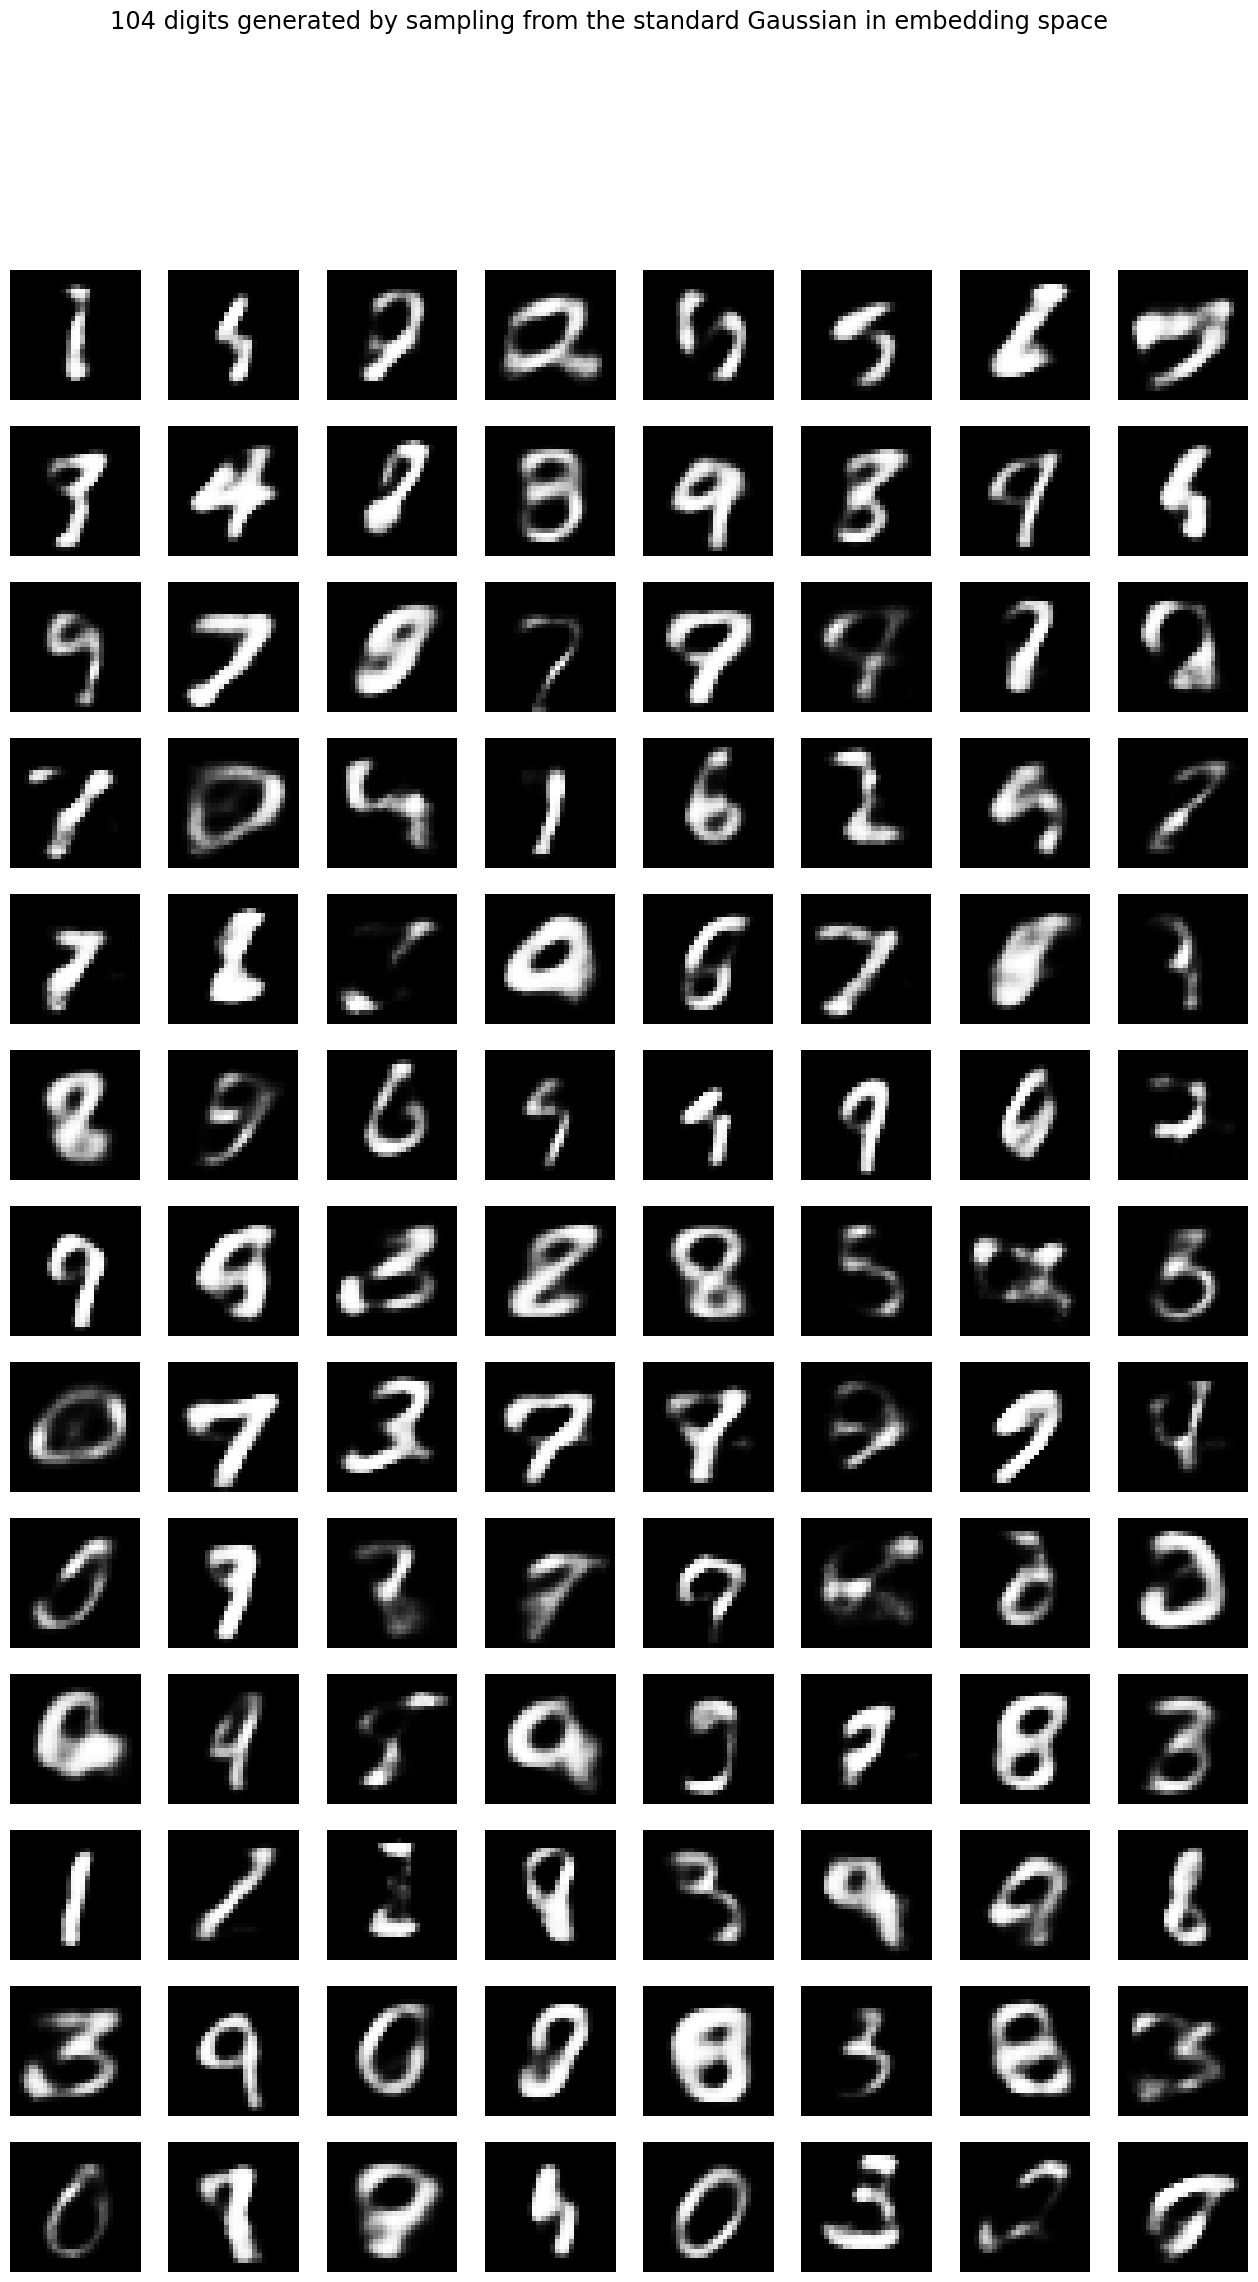

In [15]:
# Sample (about) 100 times (want row size of 8, 100/8 ~= 13)
zs = noise = torch.randn(104, pars.d).to(pars.device)
decoded_zs = net.Decoder(zs).cpu().detach().numpy()
# Display the generated digits
show_digits(decoded_zs, 13, 8, "104 digits generated by sampling from the standard Gaussian in embedding space")

# Tuning the model
Here we try hidden layer sizes of $128,256,512$ and embedding dimensions $d=10,20,40$, computing the FID score for each model using 1000 samples generated from the trained decoder and test set to estimate $\mu_G, \mu_D, \Sigma_G, \Sigma_D$. We use only $n=1000$ samples to estimate the distribution because the FID calculation requires the use of $np.linalg.eigs$, the time complexity of which is $O(n^3)$

The best hyperparameters for the model should be the ones with the least loss and least FID score, and we'll use these parameters to re-train the model later. However, this assumes that the FID score is correlated with loss, so we'll check whether it is indeed correlated by plotting the FID score against the loss and showing a line of best fit.



In [16]:
hs = [128, 256, 512]
ds = [10, 20, 40]

def try_params(hs, ds):
  pars=par()
  pars.device = device
  train,val,test=get_data(data_set=pars.data_set)
  train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])
  losses = {}
  fids = {}
  for h in hs:
    for d in ds:
      # Set pars
      pars.__dict__['h'] = h
      pars.__dict__['d'] = d
      # Train model
      enc = Encoder(pars)
      dec = Decoder(pars)
      net = AE(pars, enc, dec).to(pars.device)
      # Post it to the gpu if it's there.
      net.to(pars.device)
      for i in range(pars.num_epochs):
          # Run one epoch of training
          run_epoch(net,i,train, pars, num=pars.numtrain)
          # Test on validation set.
          net_test(net,val,pars)
      # Get loss after training
      loss = net_test(net,test,pars,ttype="test")
      label = f'h={h}, d={d}'
      losses[label] = loss
      # Get FID score: first, choose 1000 test images
      idxs = np.random.randint(test[1].size, size=1000)
      imgs = test[0][idxs].reshape(1000, 784)
      # now, get generated images
      reconstructed_imgs, means, vars = net(torch.from_numpy(imgs).to(pars.device))
      recs = reconstructed_imgs.cpu().detach().numpy()
      # Check distribution distance
      fid = fid_dist(imgs, recs)
      fids[label] = fid

  return losses, fids

#### (Press collapse here to hide the progress bars)

In [21]:
losses, fids = try_params(hs, ds)

data shape: (70000, 784)


  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 10])
variances torch.Size([1000, 10])
z torch.Size([1000, 10])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 307.2563


Validation set: Avg. loss: 206.8566



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 202.9266


Validation set: Avg. loss: 199.6490



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 198.1732


Validation set: Avg. loss: 195.0166



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 192.8113


Validation set: Avg. loss: 190.0015



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 189.2235


Validation set: Avg. loss: 185.8664



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 181.9107


Validation set: Avg. loss: 176.0950



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 173.7449


Validation set: Avg. loss: 167.9144



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 164.5735


Validation set: Avg. loss: 160.0827



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 158.6826


Validation set: Avg. loss: 156.1196



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 155.0423


Validation set: Avg. loss: 152.2975



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 150.0453


Validation set: Avg. loss: 144.8436



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 142.9406


Validation set: Avg. loss: 139.2023



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 138.5327


Validation set: Avg. loss: 135.4041



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 134.9037


Validation set: Avg. loss: 132.1856



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 132.0616


Validation set: Avg. loss: 129.7057



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 129.7392


Validation set: Avg. loss: 127.5657



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 127.7904


Validation set: Avg. loss: 125.7505



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 126.1933


Validation set: Avg. loss: 124.3300



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 124.6316


Validation set: Avg. loss: 122.6121



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 122.8680


Validation set: Avg. loss: 120.7967



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 121.1633


Validation set: Avg. loss: 119.1615



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 119.5730


Validation set: Avg. loss: 117.6308



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 117.9602


Validation set: Avg. loss: 116.2123



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 116.5324


Validation set: Avg. loss: 114.8649



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 115.3895


Validation set: Avg. loss: 113.8144



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 114.3317


Validation set: Avg. loss: 112.8174



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 113.4645


Validation set: Avg. loss: 111.9841



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 112.6846


Validation set: Avg. loss: 111.1659



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 111.9254


Validation set: Avg. loss: 110.5744



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 111.2816


Validation set: Avg. loss: 110.1012


Test set: Avg. loss: 111.0521



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 20])
variances torch.Size([1000, 20])
z torch.Size([1000, 20])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 303.5429


Validation set: Avg. loss: 206.5699



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 203.6827


Validation set: Avg. loss: 200.6600



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 198.6373


Validation set: Avg. loss: 194.4568



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 191.9473


Validation set: Avg. loss: 188.8982



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 185.6495


Validation set: Avg. loss: 179.9768



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 178.9205


Validation set: Avg. loss: 174.7594



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 171.1475


Validation set: Avg. loss: 165.0526



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 161.7719


Validation set: Avg. loss: 156.5741



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 153.5607


Validation set: Avg. loss: 148.1594



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 146.4730


Validation set: Avg. loss: 142.6734



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 141.7423


Validation set: Avg. loss: 138.6283



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 137.6976


Validation set: Avg. loss: 134.7346



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 133.8271


Validation set: Avg. loss: 130.3743



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 129.9976


Validation set: Avg. loss: 127.2893



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 127.2310


Validation set: Avg. loss: 125.1771



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 125.0438


Validation set: Avg. loss: 123.0632



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 123.0409


Validation set: Avg. loss: 121.1555



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 121.1389


Validation set: Avg. loss: 119.0424



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 119.2478


Validation set: Avg. loss: 117.1706



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 117.6508


Validation set: Avg. loss: 115.6266



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 116.1106


Validation set: Avg. loss: 114.1774



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 114.8480


Validation set: Avg. loss: 113.3760



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 113.7610


Validation set: Avg. loss: 112.0339



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 112.6983


Validation set: Avg. loss: 110.9757



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 111.7384


Validation set: Avg. loss: 110.1883



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 110.8823


Validation set: Avg. loss: 109.1543



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 110.0594


Validation set: Avg. loss: 108.4718



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 109.2330


Validation set: Avg. loss: 107.8262



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 108.5086


Validation set: Avg. loss: 106.9233



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 107.7540


Validation set: Avg. loss: 106.4470


Test set: Avg. loss: 107.5815



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 40])
variances torch.Size([1000, 40])
z torch.Size([1000, 40])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 299.3096


Validation set: Avg. loss: 206.9264



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 203.0066


Validation set: Avg. loss: 199.8901



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 197.6233


Validation set: Avg. loss: 193.7291



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 191.9617


Validation set: Avg. loss: 188.9533



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 186.6213


Validation set: Avg. loss: 181.9562



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 180.2668


Validation set: Avg. loss: 174.9577



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 172.7109


Validation set: Avg. loss: 167.7117



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 165.2254


Validation set: Avg. loss: 160.1592



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 156.9517


Validation set: Avg. loss: 151.7790



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 150.1954


Validation set: Avg. loss: 146.3819



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 145.3717


Validation set: Avg. loss: 141.9277



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 141.4349


Validation set: Avg. loss: 138.3529



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 138.0934


Validation set: Avg. loss: 135.2575



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 135.1554


Validation set: Avg. loss: 132.5156



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 132.2813


Validation set: Avg. loss: 129.8133



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 129.7869


Validation set: Avg. loss: 127.5727



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 127.5923


Validation set: Avg. loss: 125.4486



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 125.6089


Validation set: Avg. loss: 123.5105



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 123.8830


Validation set: Avg. loss: 121.7734



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 122.0941


Validation set: Avg. loss: 120.1179



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 120.4475


Validation set: Avg. loss: 118.5215



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 118.8660


Validation set: Avg. loss: 116.9315



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 117.3283


Validation set: Avg. loss: 115.4321



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 115.8775


Validation set: Avg. loss: 114.1685



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 114.6894


Validation set: Avg. loss: 112.9987



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 113.4816


Validation set: Avg. loss: 111.8216



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 112.4866


Validation set: Avg. loss: 110.8863



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 111.5028


Validation set: Avg. loss: 109.8706



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 110.5425


Validation set: Avg. loss: 109.0094



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 109.6119


Validation set: Avg. loss: 108.0772


Test set: Avg. loss: 109.2628



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 10])
variances torch.Size([1000, 10])
z torch.Size([1000, 10])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 267.4569


Validation set: Avg. loss: 203.9488



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 200.6152


Validation set: Avg. loss: 196.2569



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 192.7750


Validation set: Avg. loss: 187.4290



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 183.1159


Validation set: Avg. loss: 176.8900



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 173.1975


Validation set: Avg. loss: 165.4355



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 160.9911


Validation set: Avg. loss: 155.8594



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 153.6887


Validation set: Avg. loss: 149.3438



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 145.6896


Validation set: Avg. loss: 139.7880



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 137.8211


Validation set: Avg. loss: 133.9885



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 133.1402


Validation set: Avg. loss: 130.0511



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 128.9584


Validation set: Avg. loss: 125.3664



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 124.5600


Validation set: Avg. loss: 121.5847



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 121.3451


Validation set: Avg. loss: 118.8731



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 118.7573


Validation set: Avg. loss: 116.3971



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 116.5454


Validation set: Avg. loss: 114.3141



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 114.5103


Validation set: Avg. loss: 112.4853



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 112.7072


Validation set: Avg. loss: 110.8146



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 110.8820


Validation set: Avg. loss: 109.0272



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 109.2817


Validation set: Avg. loss: 107.8877



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 108.1132


Validation set: Avg. loss: 106.7832



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 107.2264


Validation set: Avg. loss: 105.9798



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 106.3744


Validation set: Avg. loss: 105.2238



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 105.6228


Validation set: Avg. loss: 104.6973



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 104.9910


Validation set: Avg. loss: 104.1064



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 104.4161


Validation set: Avg. loss: 103.5382



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 103.8637


Validation set: Avg. loss: 102.9907



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 103.3496


Validation set: Avg. loss: 102.5905



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 102.9295


Validation set: Avg. loss: 102.1436



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 102.4491


Validation set: Avg. loss: 101.6729



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 102.0556


Validation set: Avg. loss: 101.5049


Test set: Avg. loss: 102.3778



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 20])
variances torch.Size([1000, 20])
z torch.Size([1000, 20])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 265.2499


Validation set: Avg. loss: 203.9270



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 201.2618


Validation set: Avg. loss: 198.6409



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 195.3212


Validation set: Avg. loss: 190.5151



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 188.1072


Validation set: Avg. loss: 180.9846



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 175.0772


Validation set: Avg. loss: 165.4485



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 158.2689


Validation set: Avg. loss: 149.9202



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 145.8087


Validation set: Avg. loss: 140.8377



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 139.3615


Validation set: Avg. loss: 135.5024



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 134.4006


Validation set: Avg. loss: 131.1249



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 130.1655


Validation set: Avg. loss: 127.0407



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 126.0086


Validation set: Avg. loss: 122.8965



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 122.2193


Validation set: Avg. loss: 119.3712



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 119.0983


Validation set: Avg. loss: 116.6071



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 116.5063


Validation set: Avg. loss: 114.1553



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 114.2567


Validation set: Avg. loss: 112.1022



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 112.3721


Validation set: Avg. loss: 110.4780



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 110.7550


Validation set: Avg. loss: 108.8231



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 109.2883


Validation set: Avg. loss: 107.4959



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 107.9376


Validation set: Avg. loss: 106.1611



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 106.7407


Validation set: Avg. loss: 105.1804



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 105.7613


Validation set: Avg. loss: 104.0979



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 104.8523


Validation set: Avg. loss: 103.3533



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 104.1330


Validation set: Avg. loss: 102.6827



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 103.5116


Validation set: Avg. loss: 102.2025



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 102.8149


Validation set: Avg. loss: 101.6716



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 102.1835


Validation set: Avg. loss: 101.1117



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 101.6704


Validation set: Avg. loss: 100.4618



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 101.1526


Validation set: Avg. loss: 99.9363



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 100.6175


Validation set: Avg. loss: 99.5461



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 100.1852


Validation set: Avg. loss: 99.1568


Test set: Avg. loss: 100.2570



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 40])
variances torch.Size([1000, 40])
z torch.Size([1000, 40])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 266.5407


Validation set: Avg. loss: 203.4789



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 200.8810


Validation set: Avg. loss: 198.4473



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 194.3141


Validation set: Avg. loss: 190.3736



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 186.0885


Validation set: Avg. loss: 179.2260



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 174.3384


Validation set: Avg. loss: 165.9218



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 159.7668


Validation set: Avg. loss: 151.9816



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 147.9315


Validation set: Avg. loss: 142.0047



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 139.3760


Validation set: Avg. loss: 134.5908



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 132.9291


Validation set: Avg. loss: 128.9455



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 128.2163


Validation set: Avg. loss: 125.0970



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 124.3719


Validation set: Avg. loss: 121.5644



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 121.2015


Validation set: Avg. loss: 118.7121



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 118.4551


Validation set: Avg. loss: 116.1161



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 116.2207


Validation set: Avg. loss: 114.1168



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 114.4806


Validation set: Avg. loss: 112.5076



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 112.7535


Validation set: Avg. loss: 110.7688



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 111.2220


Validation set: Avg. loss: 109.3088



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 109.7302


Validation set: Avg. loss: 108.0766



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 108.4171


Validation set: Avg. loss: 107.0427



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 107.3236


Validation set: Avg. loss: 105.8017



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 106.3102


Validation set: Avg. loss: 104.8414



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 105.4303


Validation set: Avg. loss: 103.9165



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 104.4068


Validation set: Avg. loss: 103.0098



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 103.5153


Validation set: Avg. loss: 102.2128



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 102.6800


Validation set: Avg. loss: 101.3203



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 101.9042


Validation set: Avg. loss: 100.7979



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 101.2198


Validation set: Avg. loss: 99.9619



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 100.6396


Validation set: Avg. loss: 99.7214



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 100.0629


Validation set: Avg. loss: 98.9601



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 99.6067


Validation set: Avg. loss: 98.5321


Test set: Avg. loss: 99.6168



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 10])
variances torch.Size([1000, 10])
z torch.Size([1000, 10])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 242.7673


Validation set: Avg. loss: 201.5548



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 197.4310


Validation set: Avg. loss: 192.8353



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 187.6685


Validation set: Avg. loss: 179.5003



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 171.7916


Validation set: Avg. loss: 159.4313



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 152.3187


Validation set: Avg. loss: 143.9413



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 138.6051


Validation set: Avg. loss: 132.4441



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 129.4582


Validation set: Avg. loss: 125.2124



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 123.2423


Validation set: Avg. loss: 119.0746



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 117.8792


Validation set: Avg. loss: 114.4876



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 113.9938


Validation set: Avg. loss: 111.2697



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 111.4604


Validation set: Avg. loss: 109.1838



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 109.4236


Validation set: Avg. loss: 107.5931



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 107.4908


Validation set: Avg. loss: 105.5216



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 105.7088


Validation set: Avg. loss: 104.2526



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 104.3880


Validation set: Avg. loss: 102.8306



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 103.2265


Validation set: Avg. loss: 101.8486



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 102.3002


Validation set: Avg. loss: 101.1064



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 101.4663


Validation set: Avg. loss: 100.3526



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 100.7920


Validation set: Avg. loss: 99.7727



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 100.0647


Validation set: Avg. loss: 99.1091



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 99.5002


Validation set: Avg. loss: 98.9485



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 98.9829


Validation set: Avg. loss: 98.3667



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 98.5280


Validation set: Avg. loss: 97.7913



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 98.0793


Validation set: Avg. loss: 97.5778



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 97.6261


Validation set: Avg. loss: 97.2276



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 97.2178


Validation set: Avg. loss: 96.8463



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 96.7981


Validation set: Avg. loss: 96.4166



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 96.4261


Validation set: Avg. loss: 96.2991



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 96.0825


Validation set: Avg. loss: 95.9005



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 95.7757


Validation set: Avg. loss: 95.7174


Test set: Avg. loss: 96.6697



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 20])
variances torch.Size([1000, 20])
z torch.Size([1000, 20])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 244.2455


Validation set: Avg. loss: 201.5169



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 198.5996


Validation set: Avg. loss: 193.3970



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 189.5920


Validation set: Avg. loss: 181.7863



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 174.1697


Validation set: Avg. loss: 163.5268



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 155.3024


Validation set: Avg. loss: 145.2359



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 141.1596


Validation set: Avg. loss: 135.3464



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 132.7200


Validation set: Avg. loss: 127.2214



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 125.0039


Validation set: Avg. loss: 121.0142



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 119.7411


Validation set: Avg. loss: 116.5075



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 116.0404


Validation set: Avg. loss: 113.4793



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 112.8138


Validation set: Avg. loss: 109.7330



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 109.2705


Validation set: Avg. loss: 106.8618



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 106.7895


Validation set: Avg. loss: 104.8068



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 104.9220


Validation set: Avg. loss: 103.1002



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 103.3660


Validation set: Avg. loss: 101.8337



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 102.0893


Validation set: Avg. loss: 100.5833



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 100.9064


Validation set: Avg. loss: 99.6551



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 99.8557


Validation set: Avg. loss: 98.6944



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 98.8937


Validation set: Avg. loss: 98.0193



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 98.2321


Validation set: Avg. loss: 97.2242



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 97.4551


Validation set: Avg. loss: 96.5074



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 96.8939


Validation set: Avg. loss: 96.1149



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 96.2210


Validation set: Avg. loss: 95.5692



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 95.7494


Validation set: Avg. loss: 95.0253



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 95.2106


Validation set: Avg. loss: 94.6013



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 94.7542


Validation set: Avg. loss: 94.1741



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 94.2733


Validation set: Avg. loss: 93.8888



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 93.8956


Validation set: Avg. loss: 93.4938



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 93.5055


Validation set: Avg. loss: 93.2010



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 93.1241


Validation set: Avg. loss: 92.9673


Test set: Avg. loss: 93.8755



  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 40])
variances torch.Size([1000, 40])
z torch.Size([1000, 40])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 244.2662


Validation set: Avg. loss: 200.8619



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 198.6574


Validation set: Avg. loss: 193.3186



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 190.3603


Validation set: Avg. loss: 185.0029



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 177.8633


Validation set: Avg. loss: 166.1158



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 159.2378


Validation set: Avg. loss: 150.2175



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 145.5533


Validation set: Avg. loss: 139.0717



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 136.3987


Validation set: Avg. loss: 131.7622



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 129.8113


Validation set: Avg. loss: 125.6461



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 124.3101


Validation set: Avg. loss: 120.7008



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 119.5633


Validation set: Avg. loss: 116.3419



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 115.4677


Validation set: Avg. loss: 112.6450



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 112.2545


Validation set: Avg. loss: 109.6948



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 109.7796


Validation set: Avg. loss: 107.5275



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 107.6698


Validation set: Avg. loss: 105.9982



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 105.9459


Validation set: Avg. loss: 104.4047



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 104.5258


Validation set: Avg. loss: 103.1743



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 103.1665


Validation set: Avg. loss: 101.7947



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 102.0891


Validation set: Avg. loss: 100.6494



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 100.8834


Validation set: Avg. loss: 99.8868



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 99.8852


Validation set: Avg. loss: 98.7481



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 98.9101


Validation set: Avg. loss: 97.8033



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 98.0554


Validation set: Avg. loss: 97.3264



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 97.3772


Validation set: Avg. loss: 96.3753



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 96.6348


Validation set: Avg. loss: 95.9345



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 95.9810


Validation set: Avg. loss: 95.3462



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 95.4614


Validation set: Avg. loss: 94.9548



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 94.9218


Validation set: Avg. loss: 94.3149



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 94.5018


Validation set: Avg. loss: 93.9580



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 94.1158


Validation set: Avg. loss: 94.0247



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 93.7089


Validation set: Avg. loss: 93.1727


Test set: Avg. loss: 94.1443



####‎

Now, we plot the FID distance against the loss:

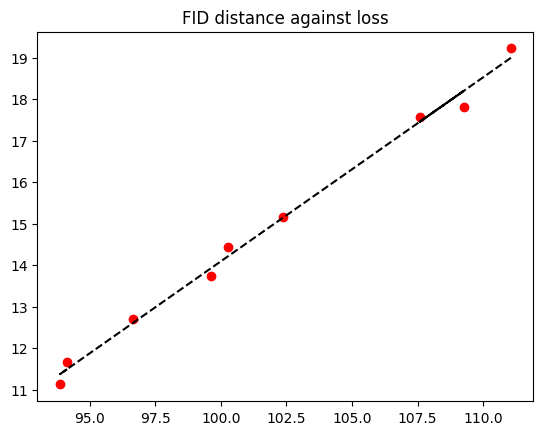

In [22]:
fidlist = list(fids.values())
losslist = list(losses.values())
fidlist = np.real(fidlist)
fig=py.figure()
ax=fig.add_subplot(1,1,1)
ax.set_title(f'FID distance against loss')
# Show linear regression
coef = np.polyfit(losslist,fidlist,1)
poly1d_fn = np.poly1d(coef)
plt.plot(losslist,fidlist, 'ro', losslist, poly1d_fn(losslist), '--k')

Finding the best parameters:

In [23]:
minloss = min(losses, key=losses.get)
minfid = min(fids, key=fids.get)
assert(minloss == minfid)
print(f"The best parameters were found to be {minloss}")

The best parameters were found to be h=512, d=20


## Comments

The loss and the FID score are indeed highly correlated (though I discarded the extremely small imaginary part of the FID distances, probably just numerical accuracy noise since covariances should necessarily be symmetric). Therefore our choice of the best parameters is justified by its lowest loss and lowest FID score. The best hidden layer being the largest possible makes some sense, as making linear models larger often increases performance, but more interesting is that a dimension of 20 for the embedding space performed the best. Perhaps with 40 we begin to overfit the digits.

# Re-training the model

Here we simply train the model with $d=20$, $h=512$.

In [24]:
pars=par()
pars.d = 20
pars.h = 512
# use GPU when possible
pars.device = device
train,val,test=get_data(data_set=pars.data_set)
# Initialize the network
enc = Encoder(pars)
dec = Decoder(pars)
net = AE(pars, enc, dec).to(pars.device)
# Post it to the gpu if it's there.
net.to(pars.device)

train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    run_epoch(net,i,train, pars, num=pars.numtrain)
    net_test(net,val,pars)

net_test(net,test,pars,ttype="test")

data shape: (70000, 784)


  0%|          | 0/50 [00:00<?, ?it/s]

means torch.Size([1000, 20])
variances torch.Size([1000, 20])
z torch.Size([1000, 20])
pred torch.Size([1000, 784])

Training set epoch 0: Average loss: 244.1651


Validation set: Avg. loss: 200.6777



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 1: Average loss: 198.5922


Validation set: Avg. loss: 194.3694



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 2: Average loss: 189.7385


Validation set: Avg. loss: 181.7591



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 3: Average loss: 175.3789


Validation set: Avg. loss: 165.4202



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 4: Average loss: 158.0399


Validation set: Avg. loss: 149.4595



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 5: Average loss: 142.7000


Validation set: Avg. loss: 135.5999



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 6: Average loss: 132.2231


Validation set: Avg. loss: 126.7255



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 7: Average loss: 125.1379


Validation set: Avg. loss: 121.3744



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 8: Average loss: 120.0601


Validation set: Avg. loss: 116.7871



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 9: Average loss: 116.2023


Validation set: Avg. loss: 112.9381



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 10: Average loss: 112.7175


Validation set: Avg. loss: 110.3058



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 11: Average loss: 110.0968


Validation set: Avg. loss: 108.0195



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 12: Average loss: 108.0424


Validation set: Avg. loss: 106.0967



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 13: Average loss: 106.2940


Validation set: Avg. loss: 104.5115



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 14: Average loss: 104.7079


Validation set: Avg. loss: 103.1029



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 15: Average loss: 103.3272


Validation set: Avg. loss: 101.7909



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 16: Average loss: 101.9661


Validation set: Avg. loss: 100.3742



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 17: Average loss: 100.6217


Validation set: Avg. loss: 99.4392



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 18: Average loss: 99.6350


Validation set: Avg. loss: 98.3778



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 19: Average loss: 98.6487


Validation set: Avg. loss: 97.7949



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 20: Average loss: 97.9211


Validation set: Avg. loss: 96.9468



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 21: Average loss: 97.1833


Validation set: Avg. loss: 96.2518



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 22: Average loss: 96.5738


Validation set: Avg. loss: 95.7690



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 23: Average loss: 95.8955


Validation set: Avg. loss: 95.2973



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 24: Average loss: 95.4076


Validation set: Avg. loss: 94.9454



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 25: Average loss: 94.8673


Validation set: Avg. loss: 94.3943



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 26: Average loss: 94.4740


Validation set: Avg. loss: 93.9971



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 27: Average loss: 94.0639


Validation set: Avg. loss: 93.5761



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 28: Average loss: 93.6196


Validation set: Avg. loss: 93.3528



  0%|          | 0/50 [00:00<?, ?it/s]


Training set epoch 29: Average loss: 93.1937


Validation set: Avg. loss: 92.9112


Test set: Avg. loss: 93.8606



93.8605625

# Best generative reconstructions

After training the model with better parameters, we try again to generate digits via the decoder. The digits still look a bit phantasmal, but the performance is certainly better than default parameters.

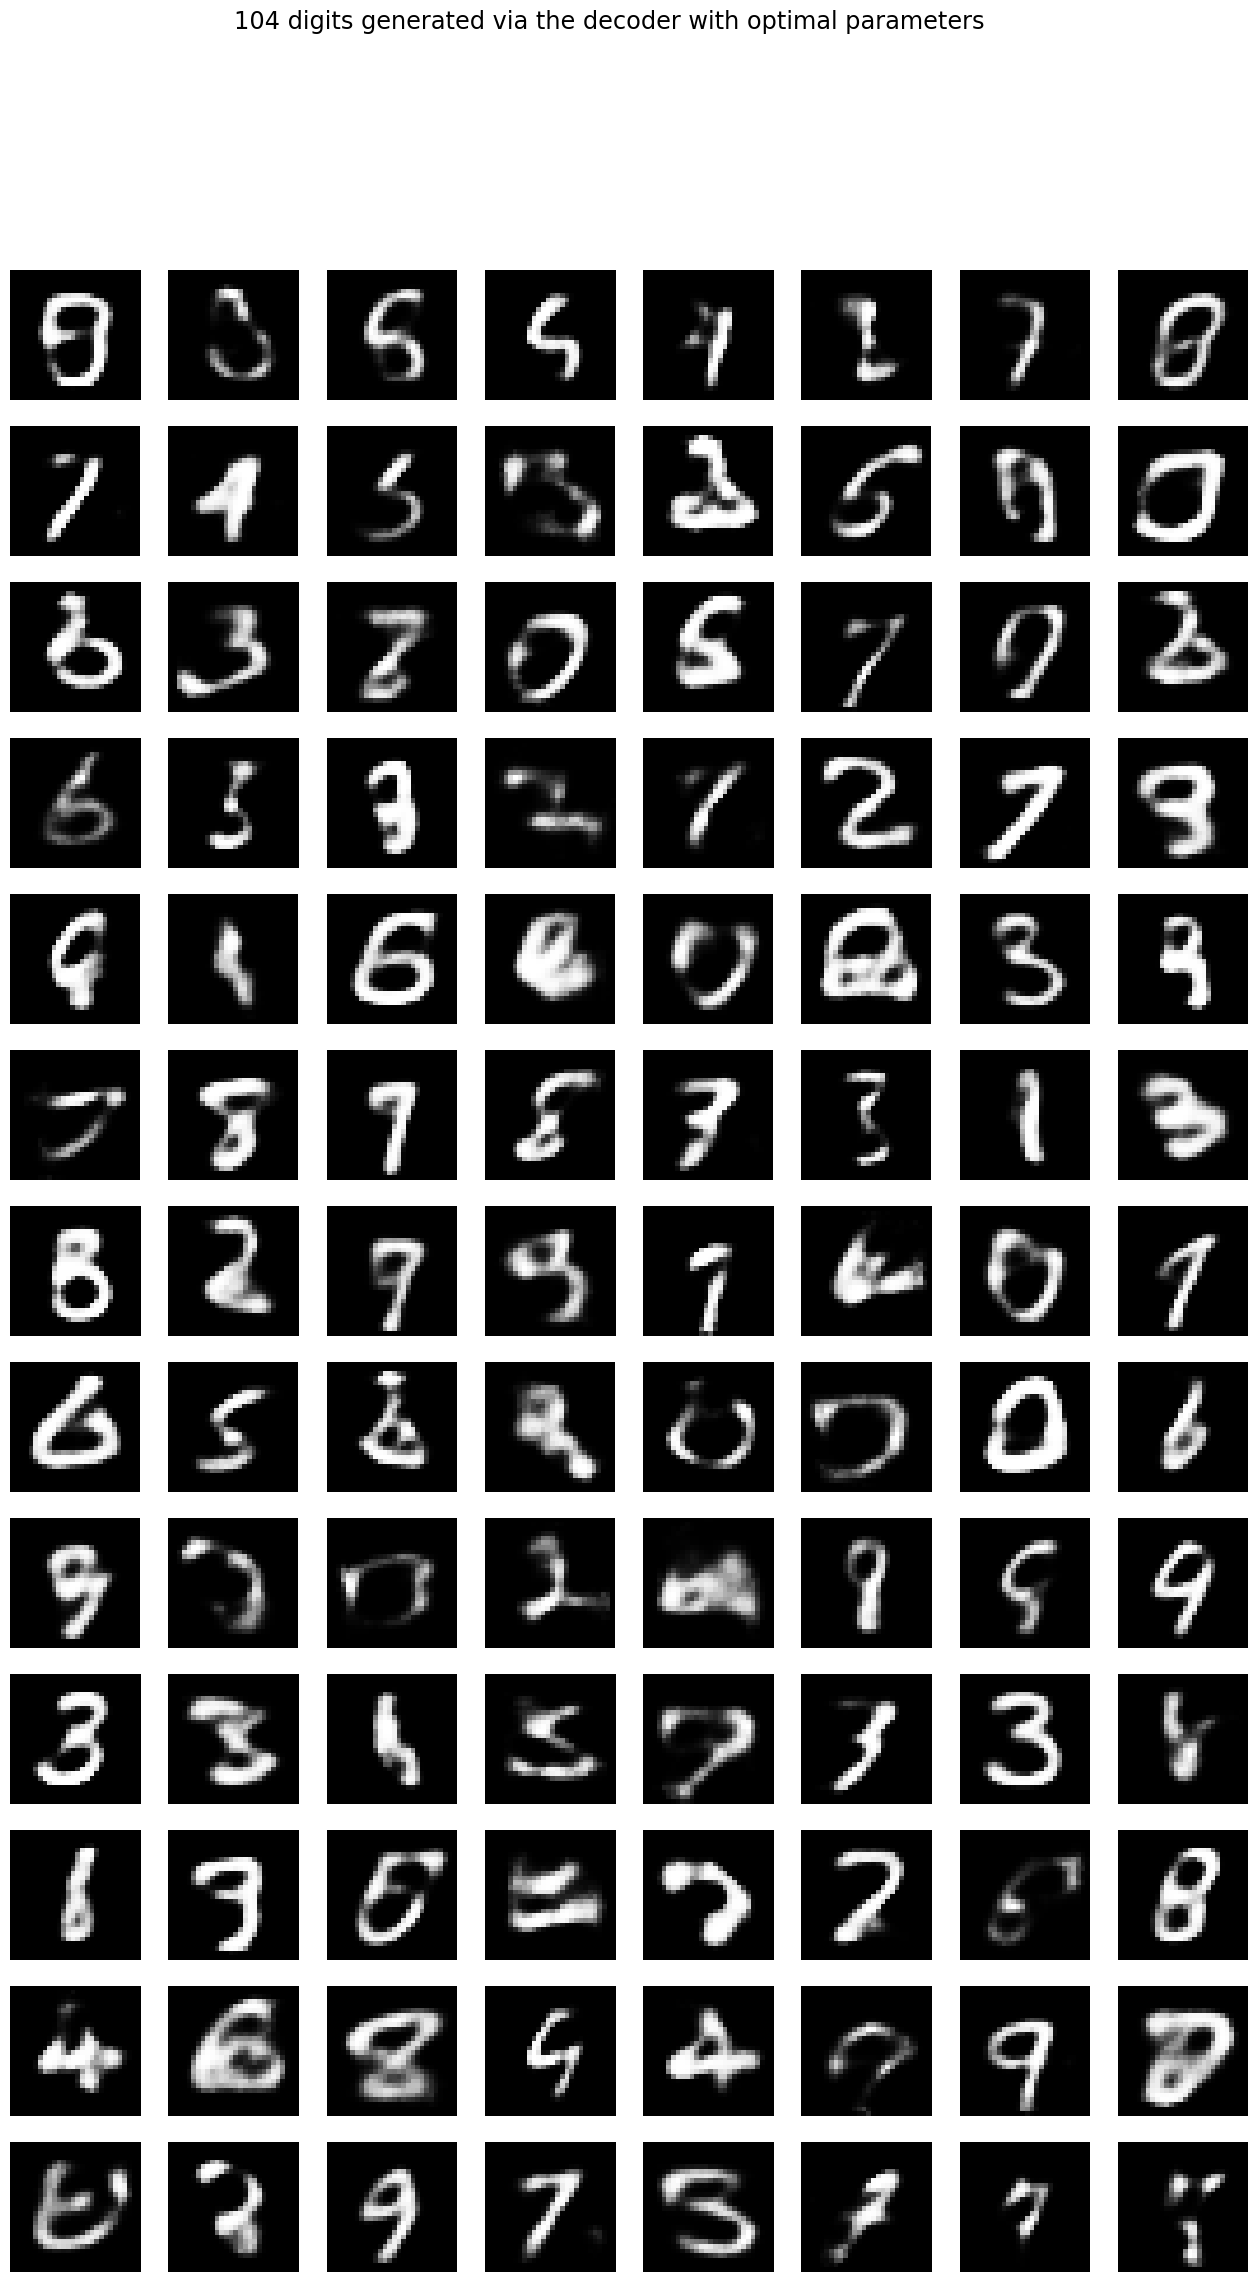

In [28]:
# Sample (about) 100 times (want row size of 8, 100/8 ~= 13)
zs = noise = torch.randn(104, pars.d).to(pars.device)
decoded_zs = net.Decoder(zs).cpu().detach().numpy()
# Display the generated digits
show_digits(decoded_zs, 13, 8, "104 digits generated via the decoder with optimal parameters")